# Hybrid AutoRec-NCF for Ranking (Implicit Feedback)

## Motivation

This notebook adapts the Hybrid AutoRec-NCF model for **implicit feedback** ranking tasks.

### Key Features:

1. **Data**: Binary interactions (ratings >= 4 as positive, 0 otherwise)
2. **Loss**: BCEWithLogitsLoss for binary classification
3. **Negative Sampling**: Sample negative items during training
4. **Evaluation**: HR@K and NDCG@K metrics (same as NCF)

### Approach:

- Filter ratings >= 4 as positive interactions
- Use negative sampling (NUM_NG negatives per positive)
- Train with binary cross-entropy loss
- Evaluate using HR@K and NDCG@K metrics

In [16]:
import os
import sys
import time

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)


import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Local imports
from helpers.data_downloader import download_ml1m_dataset
from helpers.ranking_metrics import hit, ndcg
from ncf.utils.ml_to_ncf import preprocess_ml1m_to_ncf_format
from ncf.utils.load_all_data import load_all_data

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [17]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_dims=(256, 128),
        dropout_rate: float = 0.1,
    ):
        """
        Args:
            input_dim: dimensionality of input vector (e.g. user interaction vector)
            latent_dim: size of bottleneck (MUST match NCF latent_dim)
            hidden_dims: encoder hidden layer sizes
            dropout_rate: dropout applied to hidden layers
        """
        super().__init__()

        # =======================
        # Encoder
        # =======================
        encoder_layers = []
        prev_dim = input_dim

        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = h

        # Bottleneck (NO activation)
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # =======================
        # Decoder
        # =======================
        decoder_layers = []
        prev_dim = latent_dim

        for h in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = h

        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        decoder_layers.append(nn.Sigmoid())  # For binary reconstruction

        self.decoder = nn.Sequential(*decoder_layers)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z

In [18]:
class NCF(nn.Module):
    def __init__(
        self,
        latent_dim,
        mlp_layers=(128, 64),
        dropout_rate=0.1,
    ):
        super().__init__()

        # =======================
        # GMF (pure interaction)
        # =======================
        # No parameters here by design

        # =======================
        # MLP
        # =======================
        mlp_modules = []
        input_dim = latent_dim * 2

        for h in mlp_layers:
            mlp_modules.append(nn.Linear(input_dim, h))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(dropout_rate))
            input_dim = h

        self.mlp = nn.Sequential(*mlp_modules)

        # =======================
        # Final prediction layer
        # =======================
        mlp_out_dim = mlp_layers[-1] if len(mlp_layers) > 0 else input_dim
        self.output = nn.Linear(latent_dim + mlp_out_dim, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, user_z, item_z):
        # GMF branch
        gmf_out = user_z * item_z  # pure element-wise product

        # MLP branch
        mlp_input = torch.cat([user_z, item_z], dim=1)
        mlp_out = self.mlp(mlp_input)

        # Final prediction
        concat = torch.cat([gmf_out, mlp_out], dim=1)
        logits = self.output(concat)

        # Return logits (use BCEWithLogitsLoss)
        return logits.squeeze(-1)

In [19]:
class HybridAutoRecNCF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, mlp_layers):
        super().__init__()

        self.user_autorec = AutoEncoder(num_items, latent_dim)
        self.item_autorec = AutoEncoder(num_users, latent_dim)

        self.ncf = NCF(latent_dim, mlp_layers)

    def forward(self, user_vecs, item_vecs, user_ids, item_ids):
        # AutoRec forward
        # user_vecs: (batch_size, num_items) - each row is a user's interaction vector
        # item_vecs: (batch_size, num_users) - each row is an item's interaction vector
        user_recon, user_z = self.user_autorec(user_vecs)
        item_recon, item_z = self.item_autorec(item_vecs)

        # Each element in the batch corresponds to a (user, item) pair
        # user_z[i] is the latent for the user in pair i
        # item_z[i] is the latent for the item in pair i
        pred = self.ncf(user_z, item_z)
        return pred, user_recon, item_recon

In [20]:
def reconstruction_loss(pred, target, mask):
    """Binary cross-entropy loss for reconstruction (implicit feedback)"""
    # pred and target are in [0, 1] (sigmoid output)
    # mask indicates which elements to consider
    bce = F.binary_cross_entropy(pred, target, reduction='none')
    return (bce * mask).sum() / mask.sum()


def interaction_loss(pred_logits, labels):
    """Binary cross-entropy loss for interaction prediction"""
    return F.binary_cross_entropy_with_logits(pred_logits, labels.float())


def total_loss(pred_logits, labels,
               user_recon, user_vecs, user_mask,
               item_recon, item_vecs, item_mask,
               alpha=1.0, beta=1.0):
    rec_u = reconstruction_loss(user_recon, user_vecs, user_mask)
    rec_i = reconstruction_loss(item_recon, item_vecs, item_mask)
    inter = interaction_loss(pred_logits, labels)
    return alpha * (rec_u + rec_i) + beta * inter

In [21]:
def train(model, dataloader, optimizer, device):
    model.train()
    total = 0.0

    for batch in dataloader:
        (user_ids, item_ids, labels,
         user_vecs, item_vecs,
         user_mask, item_mask) = batch

        user_ids = user_ids.to(device).squeeze()
        item_ids = item_ids.to(device).squeeze()
        labels = labels.to(device).squeeze()
        user_vecs = user_vecs.to(device)
        item_vecs = item_vecs.to(device)
        user_mask = user_mask.to(device)
        item_mask = item_mask.to(device)

        optimizer.zero_grad()

        pred_logits, user_recon, item_recon = model(
            user_vecs, item_vecs, user_ids, item_ids
        )

        loss = total_loss(
            pred_logits, labels,
            user_recon, user_vecs, user_mask,
            item_recon, item_vecs, item_mask
        )

        loss.backward()
        optimizer.step()
        total += loss.item()

    return total / len(dataloader)

In [22]:
# Paths and hyperparameters (same as NCF)
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

# Hyperparameters (same as NCF)
LEARNING_RATE = 0.001
BATCH_SIZE = 256
EPOCHS = 50
TOP_K = 10
NUM_NG = 4  # Number of negatives per positive during training
TEST_NUM_NG = 99  # Number of negatives per positive during testing
EARLY_STOPPING_PATIENCE = 10
MIN_DELTA = 0.0001

# Evaluation settings (for faster training)
# Reduce MAX_TEST_SAMPLES to speed up evaluation (None = all 115k samples, very slow)
# Recommended: 1000-3000 for fast training, 5000+ for more accurate metrics
MAX_TEST_SAMPLES = 2000  # Maximum test samples to evaluate per epoch (None = all, but slower)
EVAL_EVERY_N_EPOCHS = 1  # Evaluate every N epochs (1 = every epoch, 2 = every 2 epochs, etc.)

# Download and preprocess (exactly same as NCF)
ratings_file = download_ml1m_dataset(DATA_DIR)

# Preprocess to NCF format (filters ratings >= 4, creates train/test split)
train_rating_path, test_rating_path, test_negative_path, user_num, item_num, train_mat = \
    preprocess_ml1m_to_ncf_format(ratings_file, data_dir=DATA_DIR, test_negatives=TEST_NUM_NG)

# Load data (exactly same as NCF)
train_data, test_data_full, user_num, item_num, train_mat = load_all_data(
    train_rating_path, test_negative_path
)

# Extract only positive test samples and load negatives for on-the-fly generation
# test_data_full from load_all_data contains: [pos1, neg1, neg2, ..., neg99, pos2, neg1, ...]
# We need to extract only the positive samples (every TEST_NUM_NG+1 samples)
test_data_positives = []
test_negative_samples = {}

# Read test negative file directly to get positive samples and their negatives
with open(test_negative_path, 'r') as f:
    for line in f:
        arr = line.strip().split('\t')
        if not arr[0]:  # Skip empty lines
            continue
        positive_pair = eval(arr[0])
        u, i = positive_pair[0], positive_pair[1]
        test_data_positives.append([u, i])
        negatives = [int(neg) for neg in arr[1:] if neg]
        test_negative_samples[(u, i)] = negatives

print(f"✓ Extracted {len(test_data_positives)} positive test samples")
print(f"  - Test negatives will be generated on-the-fly during evaluation")

✓ Dataset already exists at /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
✓ Training matrix created: 460225 interactions
Loading training data from /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m.train.rating...
✓ Loaded 460225 training pairs
  - Users: 6038
  - Items: 3533
✓ Extracted 115056 positive test samples
  - Test negatives will be generated on-the-fly during evaluation


In [23]:
# Data is already preprocessed (ratings >= 4 filtered, train/test split done)
# train_mat is a sparse matrix of shape (user_num, item_num)
# Convert to dense for AutoEncoder input
train_mat_dense = train_mat.toarray().astype(np.float32)

print(f"✓ Data loaded and preprocessed")
print(f"  - Users: {user_num}")
print(f"  - Items: {item_num}")
print(f"  - Training interactions: {train_mat.nnz:,}")
print(f"  - Test positive samples: {len(test_data_positives):,}")
print(f"  - Test samples per evaluation: {len(test_data_positives) * (TEST_NUM_NG + 1):,} (generated on-the-fly)")
print("=" * 70)

✓ Data loaded and preprocessed
  - Users: 6038
  - Items: 3533
  - Training interactions: 460,225
  - Test positive samples: 115,056
  - Test samples per evaluation: 11,505,600 (generated on-the-fly)


In [24]:
# Create test matrix for evaluation (only positive interactions)
test_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
for u, i in train_data:  # train_data contains positive pairs
    if (u, i) not in train_mat:  # Only add if not in training
        test_mat[u, i] = 1.0

test_mat_dense = test_mat.toarray().astype(np.float32)

In [25]:
# Dataset class for hybrid model (similar to NCFData but with full vectors)
class HybridRankingDataset(data.Dataset):
    def __init__(self, features, num_item, train_mat_dense, train_mat_sparse=None, num_ng=0, is_training=None, test_negative_samples=None):
        """
        Args:
            features: List of [user, item] pairs (positive samples)
            num_item: Total number of items
            train_mat_dense: Dense interaction matrix (num_users, num_items) for AutoEncoder input
            train_mat_sparse: Sparse matrix for checking if (user, item) exists (for negative sampling)
            num_ng: Number of negative samples per positive
            is_training: Whether this is training data (needs negative sampling)
            test_negative_samples: Dict mapping (user, item) -> list of negative items (for test set)
        """
        super(HybridRankingDataset, self).__init__()
        
        self.features_ps = features  # Positive samples
        self.num_item = num_item
        self.train_mat_dense = train_mat_dense
        self.train_mat_sparse = train_mat_sparse if train_mat_sparse is not None else train_mat_dense
        self.num_ng = num_ng
        self.is_training = is_training
        self.test_negative_samples = test_negative_samples  # For on-the-fly negative generation
        
        # Create masks (1 where interaction exists, 0 otherwise)
        self.user_mask = (train_mat_dense > 0).astype(np.float32)
        self.item_mask = (train_mat_dense.T > 0).astype(np.float32)
        
        # Initialize labels
        self.labels = [0 for _ in range(len(features))]
        
        # These will be populated by ng_sample() during training
        self.features_ng = []
        self.features_fill = []
        self.labels_fill = []
    
    def ng_sample(self):
        """Generate negative samples for training (same as NCFData) - called per epoch"""
        assert self.is_training, 'Negative sampling only needed during training'
        
        self.features_ng = []
        
        # For each positive pair, generate num_ng negative samples
        for x in self.features_ps:
            u = x[0]  # User ID
            # Generate num_ng negative items for this user
            for t in range(self.num_ng):
                # Sample a random item
                j = np.random.randint(self.num_item)
                
                # Make sure this item is NOT in the user's training set
                # Keep sampling until we find a negative item
                while (u, j) in self.train_mat_sparse:
                    j = np.random.randint(self.num_item)
                
                # Add this negative sample
                self.features_ng.append([u, j])
        
        # Create labels: 1 for positives, 0 for negatives
        labels_ps = [1 for _ in range(len(self.features_ps))]
        labels_ng = [0 for _ in range(len(self.features_ng))]
        
        # Combine positives and negatives
        self.features_fill = self.features_ps + self.features_ng
        self.labels_fill = labels_ps + labels_ng
        
        print(f"✓ Generated {len(self.features_ng)} negative samples")
        print(f"  - Total samples (positives + negatives): {len(self.features_fill)}")
    
    def __len__(self):
        if self.is_training:
            return (self.num_ng + 1) * len(self.labels) if self.features_fill else 0
        else:
            # For test set, return number of positive samples
            # Negatives will be generated on-the-fly during __getitem__
            return len(self.features_ps)
    
    def __getitem__(self, idx):
        if self.is_training:
            # During training: use combined features (positives + negatives)
            features = self.features_fill
            labels = self.labels_fill
            user = features[idx][0]
            item = features[idx][1]
            label = labels[idx]
        else:
            # During testing: generate negatives on-the-fly
            # idx corresponds to a positive test sample
            user, item = self.features_ps[idx]
            label = 1.0  # Positive sample
            
            # Get negatives for this user-item pair
            if self.test_negative_samples and (user, item) in self.test_negative_samples:
                negatives = self.test_negative_samples[(user, item)]
            else:
                # Fallback: generate negatives on-the-fly if not in dict
                negatives = []
                attempts = 0
                max_attempts = self.num_ng * 10
                while len(negatives) < self.num_ng and attempts < max_attempts:
                    neg_item = np.random.randint(self.num_item)
                    if (user, neg_item) not in self.train_mat_sparse:
                        negatives.append(neg_item)
                    attempts += 1
        
        # Get user vector (interactions across all items)
        user_vec = torch.FloatTensor(self.train_mat_dense[user])
        
        # Get item vector (interactions across all users)
        item_vec = torch.FloatTensor(self.train_mat_dense[:, item])
        
        # Get masks
        user_mask = torch.FloatTensor(self.user_mask[user])
        item_mask = torch.FloatTensor(self.item_mask[item])
        
        return (
            torch.LongTensor([user]),
            torch.LongTensor([item]),
            torch.FloatTensor([label]),
            user_vec,
            item_vec,
            user_mask,
            item_mask
        )

# Create datasets
train_dataset = HybridRankingDataset(
    train_data,
    item_num,
    train_mat_dense,
    train_mat,
    num_ng=NUM_NG,
    is_training=True
)

# Test dataset: only store positive samples, generate negatives on-the-fly
test_dataset = HybridRankingDataset(
    test_data_positives,  # Only positive samples
    item_num,
    train_mat_dense,
    train_mat,
    num_ng=TEST_NUM_NG,  # Number of negatives to generate per positive
    is_training=False,
    test_negative_samples=test_negative_samples  # Pre-loaded negatives
)

# Generate negative samples for training (will be regenerated each epoch)
train_dataset.ng_sample()

print(f"✓ Datasets created")
print(f"  - Train samples: {len(train_dataset):,}")
print(f"  - Test positive samples: {len(test_dataset):,}")
print(f"  - Test samples per evaluation: {len(test_dataset) * (TEST_NUM_NG + 1):,} (generated on-the-fly)")
print("=" * 70)

✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125
✓ Datasets created
  - Train samples: 2,301,125
  - Test positive samples: 115,056
  - Test samples per evaluation: 11,505,600 (generated on-the-fly)


In [26]:
# Create data loaders (exactly same as NCF)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# For test loader, we need to create batches that include negatives
# Each batch should contain 1 positive + TEST_NUM_NG negatives for a user
class TestDataLoader:
    """Custom test data loader that generates negatives on-the-fly"""
    def __init__(self, test_dataset, batch_size=1):
        self.test_dataset = test_dataset
        self.batch_size = batch_size  # Number of users per batch
        self.num_positives = len(test_dataset)
    
    def __len__(self):
        return self.num_positives  # One batch per positive test sample
    
    def __iter__(self):
        for idx in range(self.num_positives):
            # Get positive sample
            user, item, label, user_vec, item_vec, user_mask, item_mask = self.test_dataset[idx]
            
            # Get negatives for this user-item pair
            user_id = user.item()
            item_id = item.item()
            
            if self.test_dataset.test_negative_samples and (user_id, item_id) in self.test_dataset.test_negative_samples:
                negatives = self.test_dataset.test_negative_samples[(user_id, item_id)]
            else:
                # Fallback: generate negatives
                negatives = []
                attempts = 0
                while len(negatives) < self.test_dataset.num_ng and attempts < self.test_dataset.num_ng * 10:
                    neg_item = np.random.randint(self.test_dataset.num_item)
                    if (user_id, neg_item) not in self.test_dataset.train_mat_sparse:
                        negatives.append(neg_item)
                    attempts += 1
            
            # Create batch: [positive, neg1, neg2, ..., neg99]
            batch_users = [user_id] + [user_id] * len(negatives)
            batch_items = [item_id] + negatives
            batch_labels = [1.0] + [0.0] * len(negatives)
            
            # Get vectors for all items in batch
            batch_user_vecs = []
            batch_item_vecs = []
            batch_user_masks = []
            batch_item_masks = []
            
            for u, i in zip(batch_users, batch_items):
                u_vec = torch.FloatTensor(self.test_dataset.train_mat_dense[u])
                i_vec = torch.FloatTensor(self.test_dataset.train_mat_dense[:, i])
                u_mask = torch.FloatTensor(self.test_dataset.user_mask[u])
                i_mask = torch.FloatTensor(self.test_dataset.item_mask[i])
                
                batch_user_vecs.append(u_vec)
                batch_item_vecs.append(i_vec)
                batch_user_masks.append(u_mask)
                batch_item_masks.append(i_mask)
            
            yield (
                torch.LongTensor(batch_users),
                torch.LongTensor(batch_items),
                torch.FloatTensor(batch_labels),
                torch.stack(batch_user_vecs),
                torch.stack(batch_item_vecs),
                torch.stack(batch_user_masks),
                torch.stack(batch_item_masks)
            )

test_loader = TestDataLoader(test_dataset, batch_size=1)

print(f"✓ Data loaders created")
print(f"  - Train batch size: {BATCH_SIZE}")
print(f"  - Test: {len(test_dataset)} positive samples (negatives generated on-the-fly)")
print(f"  - Test batch size: {TEST_NUM_NG + 1} (1 positive + {TEST_NUM_NG} negatives per user)")

✓ Data loaders created
  - Train batch size: 256
  - Test: 115056 positive samples (negatives generated on-the-fly)
  - Test batch size: 100 (1 positive + 99 negatives per user)


In [27]:
# Initialize model and optimizer
latent_dim = 64
mlp_layers = [128, 64]

model = HybridAutoRecNCF(
    user_num, item_num, latent_dim, mlp_layers
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5
)

print(f"✓ Model initialized")
print(f"  - Users: {user_num}, Items: {item_num}")
print(f"  - Latent dim: {latent_dim}")
print(f"  - MLP layers: {mlp_layers}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ Model initialized
  - Users: 6038, Items: 3533
  - Latent dim: 64
  - MLP layers: [128, 64]
  - Total parameters: 5,100,324


In [28]:
# Extended evaluation function with detailed metrics (for visualization)
def evaluate_ranking_metrics_detailed(model, train_mat_dense, test_mat_dense, num_users, num_items, top_k=10, device=None, return_details=False):
    """Extended version that returns detailed user-level metrics"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    train_mat_tensor = torch.FloatTensor(train_mat_dense).to(device)
    test_mat_np = test_mat_dense
    train_mask = (train_mat_dense > 0)
    
    batch_size_users = 256
    predictions = np.zeros((num_users, num_items), dtype=np.float32)
    
    with torch.no_grad():
        for start_idx in range(0, num_users, batch_size_users):
            end_idx = min(start_idx + batch_size_users, num_users)
            batch_size = end_idx - start_idx
            user_vecs_batch = train_mat_tensor[start_idx:end_idx]
            
            for item_id in range(num_items):
                item_vec_full = train_mat_tensor[:, item_id]
                item_vecs_batch = item_vec_full.unsqueeze(0).expand(batch_size, -1)
                user_ids_batch = torch.arange(start_idx, end_idx, device=device)
                item_ids_batch = torch.full((batch_size,), item_id, device=device)
                pred_batch, _, _ = model(user_vecs_batch, item_vecs_batch, user_ids_batch, item_ids_batch)
                predictions[start_idx:end_idx, item_id] = pred_batch.cpu().numpy()
    
    predictions = predictions * (~train_mask).astype(np.float32) - train_mask.astype(np.float32) * 1e10
    
    HR_list = []
    NDCG_list = []
    user_test_counts = []
    
    for user_id in range(num_users):
        test_items = set(np.where(test_mat_np[user_id] > 0)[0])
        if len(test_items) == 0:
            continue
        
        user_predictions = predictions[user_id]
        top_k_indices = np.argsort(user_predictions)[-top_k:][::-1]
        top_k_items = top_k_indices.tolist()
        
        user_hr = []
        user_ndcg = []
        for test_item in test_items:
            user_hr.append(hit(test_item, top_k_items))
            user_ndcg.append(ndcg(test_item, top_k_items))
        
        HR_list.append(np.mean(user_hr) if user_hr else 0.0)
        NDCG_list.append(np.mean(user_ndcg) if user_ndcg else 0.0)
        user_test_counts.append(len(test_items))
    
    if len(HR_list) == 0:
        return 0.0, 0.0, {}
    
    details = {
        'user_hr': HR_list,
        'user_ndcg': NDCG_list,
        'user_test_counts': user_test_counts,
        'predictions': predictions
    }
    
    return np.mean(HR_list), np.mean(NDCG_list), details

In [29]:
# Evaluation function (same format as NCF)
def evaluate_metrics(model, test_loader, top_k, device='cuda', max_test_samples=None):
    """
    Evaluate HR@K and NDCG@K (same as NCF evaluation)
    
    Args:
        model: The model to evaluate
        test_loader: Test data loader
        top_k: Top-K for ranking metrics
        device: Device to run evaluation on
        max_test_samples: Maximum number of test samples to evaluate (None = all, for speed)
    """
    model.eval()
    
    HR_list = []
    NDCG_list = []
    
    # Limit number of test samples for faster evaluation
    test_samples_processed = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            # Stop if we've processed enough samples
            if max_test_samples is not None and test_samples_processed >= max_test_samples:
                break
                
            (user_ids, item_ids, labels,
             user_vecs, item_vecs,
             user_mask, item_mask) = batch
            
            # Move to device
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            user_vecs = user_vecs.to(device)
            item_vecs = item_vecs.to(device)
            
            # Get predictions
            pred_logits, _, _ = model(user_vecs, item_vecs, user_ids, item_ids)
            predictions = pred_logits
            
            # Get top-K items (from this batch which contains 1 positive + negatives)
            _, indices = torch.topk(predictions, min(top_k, len(predictions)))
            
            # Get the actual item IDs for top-K recommendations
            recommends = torch.take(item_ids, indices).cpu().numpy().tolist()
            
            # Ground truth item is the first one (positive sample, label=1.0)
            gt_item = item_ids[0].item()
            
            HR_list.append(hit(gt_item, recommends))
            NDCG_list.append(ndcg(gt_item, recommends))
            
            test_samples_processed += 1
    
    mean_HR = np.mean(HR_list) if HR_list else 0.0
    mean_NDCG = np.mean(NDCG_list) if NDCG_list else 0.0
    
    
    # Collect user-level details if requested
    if return_details:
        user_hr_list = []
        user_ndcg_list = []
        user_test_counts_list = []
        
        for user_id in range(num_users):
            test_items = set(np.where(test_mat_np[user_id] > 0)[0])
            if len(test_items) == 0:
                continue
            
            user_predictions = predictions[user_id]
            top_k_indices = np.argsort(user_predictions)[-top_k:][::-1]
            top_k_items = top_k_indices.tolist()
            
            user_hr = []
            user_ndcg = []
            for test_item in test_items:
                user_hr.append(hit(test_item, top_k_items))
                user_ndcg.append(ndcg(test_item, top_k_items))
            
            user_hr_list.append(np.mean(user_hr) if user_hr else 0.0)
            user_ndcg_list.append(np.mean(user_ndcg) if user_ndcg else 0.0)
            user_test_counts_list.append(len(test_items))
        
        details = {
            'user_hr': np.array(user_hr_list),
            'user_ndcg': np.array(user_ndcg_list),
            'user_test_counts': np.array(user_test_counts_list)
        }
        return mean_HR, mean_NDCG, details
    
    return mean_HR, mean_NDCG

# Extended evaluation function for detailed metrics
def evaluate_ranking_metrics_detailed(model, train_mat_dense, test_mat_dense, num_users, num_items, top_k=10, device=None, return_details=False):
    """
    Evaluate HitRate@K and NDCG@K metrics.
    
    For each user:
    1. Get predictions for all items using training data
    2. Mask out items seen in training
    3. Get top-K items
    4. Calculate HR and NDCG based on test items
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    
    # Convert to tensors
    train_mat_tensor = torch.FloatTensor(train_mat_dense).to(device)
    test_mat_np = test_mat_dense
    
    # Get training mask
    train_mask = (train_mat_dense > 0)
    
    # Predict scores for all user-item pairs
    batch_size_users = 256
    predictions = np.zeros((num_users, num_items), dtype=np.float32)
    
    with torch.no_grad():
        for start_idx in range(0, num_users, batch_size_users):
            end_idx = min(start_idx + batch_size_users, num_users)
            batch_size = end_idx - start_idx
            
            # Get user vectors (interactions across all items from training)
            user_vecs_batch = train_mat_tensor[start_idx:end_idx]  # (batch_size, num_items)
            
            # For each item, get its interaction vector across all users
            for item_id in range(num_items):
                # Get item vector (interactions across all users from training)
                item_vec_full = train_mat_tensor[:, item_id]  # (num_users,)
                # Expand to match batch size
                item_vecs_batch = item_vec_full.unsqueeze(0).expand(batch_size, -1)  # (batch_size, num_users)
                
                # Create dummy user_ids and item_ids
                user_ids_batch = torch.arange(start_idx, end_idx, device=device)
                item_ids_batch = torch.full((batch_size,), item_id, device=device)
                
                # Get predictions (logits)
                pred_batch, _, _ = model(
                    user_vecs_batch, item_vecs_batch, user_ids_batch, item_ids_batch
                )
                
                predictions[start_idx:end_idx, item_id] = pred_batch.cpu().numpy()
    
    # Mask out items seen in training
    predictions = predictions * (~train_mask).astype(np.float32) - train_mask.astype(np.float32) * 1e10
    
    HR_list = []
    NDCG_list = []
    
    # Calculate metrics for each user
    for user_id in range(num_users):
        # Get ground truth items for this user (items interacted with in test set)
        test_items = set(np.where(test_mat_np[user_id] > 0)[0])
        
        # Skip if user has no test items
        if len(test_items) == 0:
            continue
        
        # Get top-K items for this user
        user_predictions = predictions[user_id]
        top_k_indices = np.argsort(user_predictions)[-top_k:][::-1]
        top_k_items = top_k_indices.tolist()
        
        # Calculate metrics for each test item
        user_hr = []
        user_ndcg = []
        for test_item in test_items:
            user_hr.append(hit(test_item, top_k_items))
            user_ndcg.append(ndcg(test_item, top_k_items))
        
        # Average over test items for this user
        HR_list.append(np.mean(user_hr) if user_hr else 0.0)
        NDCG_list.append(np.mean(user_ndcg) if user_ndcg else 0.0)
    
    # Calculate average metrics
    if len(HR_list) == 0:
        return 0.0, 0.0
    
    mean_HR = np.mean(HR_list)
    mean_NDCG = np.mean(NDCG_list)
    
    
    # Collect user-level details if requested
    if return_details:
        user_hr_list = []
        user_ndcg_list = []
        user_test_counts_list = []
        
        for user_id in range(num_users):
            test_items = set(np.where(test_mat_np[user_id] > 0)[0])
            if len(test_items) == 0:
                continue
            
            user_predictions = predictions[user_id]
            top_k_indices = np.argsort(user_predictions)[-top_k:][::-1]
            top_k_items = top_k_indices.tolist()
            
            user_hr = []
            user_ndcg = []
            for test_item in test_items:
                user_hr.append(hit(test_item, top_k_items))
                user_ndcg.append(ndcg(test_item, top_k_items))
            
            user_hr_list.append(np.mean(user_hr) if user_hr else 0.0)
            user_ndcg_list.append(np.mean(user_ndcg) if user_ndcg else 0.0)
            user_test_counts_list.append(len(test_items))
        
        details = {
            'user_hr': np.array(user_hr_list),
            'user_ndcg': np.array(user_ndcg_list),
            'user_test_counts': np.array(user_test_counts_list)
        }
        return mean_HR, mean_NDCG, details
    
    return mean_HR, mean_NDCG

In [46]:
# Simple wrapper function for evaluate_ranking_metrics
def evaluate_ranking_metrics(model, train_mat_dense, test_mat_dense, num_users, num_items, top_k=10, device=None, return_details=False):
    """
    Simple wrapper that calls evaluate_ranking_metrics_detailed.
    Accepts dense matrices for both train and test.
    """
    return evaluate_ranking_metrics_detailed(model, train_mat_dense, test_mat_dense, num_users, num_items, top_k=top_k, device=device)


In [30]:
# Training loop (same structure as NCF)
loss_function = nn.BCEWithLogitsLoss()

# Ensure total_loss is the function, not a variable
# This prevents issues if total_loss was accidentally assigned as a float in a previous run
if not callable(total_loss):
    raise RuntimeError("total_loss is not callable! Please re-run cell 5 to define the total_loss function.")

best_hr = 0.0
best_ndcg = 0.0
best_epoch = 0
patience_counter = 0

# Create model save directory
model_path = os.path.join(MODEL_PATH, 'HybridAutoRecNCF-Ranking.pth')

# Track metrics for visualization
training_history = {
    'epoch': [],
    'train_loss': [],
    'hit_rate': [],
    'ndcg': []
}

print("=" * 70)
print("Starting Training")
print("=" * 70)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Top-K for ranking metrics: {TOP_K}")
print(f"Training negatives per positive: {NUM_NG}")
print(f"Test negatives per positive: {TEST_NUM_NG}")
print("=" * 70)

for epoch in range(EPOCHS):
    # Training

    
    model.train()
    epoch_loss_sum = 0.0
    start_time = time.time()
    
    # Regenerate negative samples each epoch (same as NCF)
    train_dataset.ng_sample()
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        (user_ids, item_ids, labels,
         user_vecs, item_vecs,
         user_mask, item_mask) = batch

        user_ids = user_ids.to(device).squeeze()
        item_ids = item_ids.to(device).squeeze()
        labels = labels.to(device).squeeze()
        user_vecs = user_vecs.to(device)
        item_vecs = item_vecs.to(device)
        user_mask = user_mask.to(device)
        item_mask = item_mask.to(device)

        optimizer.zero_grad()

        pred_logits, user_recon, item_recon = model(
            user_vecs, item_vecs, user_ids, item_ids
        )

        loss = total_loss(
            pred_logits, labels,
            user_recon, user_vecs, user_mask,
            item_recon, item_vecs, item_mask
        )

        loss.backward()
        optimizer.step()
        epoch_loss_sum += loss.item()
    
    train_loss = epoch_loss_sum / len(train_loader)
    elapsed_time = time.time() - start_time
    
    # Evaluation (same as NCF) - only evaluate every N epochs or on first/last epoch
    should_evaluate = (epoch + 1) % EVAL_EVERY_N_EPOCHS == 0 or epoch == 0 or epoch == EPOCHS - 1
    
    if should_evaluate:
        print(f"  Evaluating on test set (max {MAX_TEST_SAMPLES} samples)...")
        eval_start = time.time()
        hit_rate, ndcg_score = evaluate_metrics(
            model, test_loader, TOP_K, device=device, max_test_samples=MAX_TEST_SAMPLES
        )
        eval_time = time.time() - eval_start
    else:
        # Use previous metrics to avoid breaking the history
        hit_rate = training_history['hit_rate'][-1] if training_history['hit_rate'] else 0.0
        ndcg_score = training_history['ndcg'][-1] if training_history['ndcg'] else 0.0
        eval_time = 0
        print(f"  Skipping evaluation (evaluate every {EVAL_EVERY_N_EPOCHS} epochs)")
    
    # Save best model based on HR
    if hit_rate > best_hr + MIN_DELTA:
        best_hr = hit_rate
        best_ndcg = ndcg_score
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"  ✓ New best model! (HR@{TOP_K}: {best_hr:.4f})")
        print(f"  ✓ Model saved to {model_path}")
    else:
        patience_counter += 1
    
    # Track metrics
    training_history['epoch'].append(epoch + 1)
    training_history['train_loss'].append(train_loss)
    training_history['hit_rate'].append(hit_rate)
    training_history['ndcg'].append(ndcg_score)
    
    print(f"  Time: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")
    print(f"  Loss: {train_loss:.4f}")
    print(f"  HR@{TOP_K}: {hit_rate:.4f}")
    print(f"  NDCG@{TOP_K}: {ndcg_score:.4f}")
    
    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n  Early stopping triggered (no improvement for {EARLY_STOPPING_PATIENCE} epochs)")
        break
    
    print("-" * 70)

print("=" * 70)
print("Training Complete!")
print(f"Best model at epoch {best_epoch+1} with HR@{TOP_K}: {best_hr:.4f}, NDCG@{TOP_K}: {best_ndcg:.4f}")
print(f"Model saved to: {model_path}")
print("=" * 70)

Starting Training
Epochs: 50
Batch size: 256
Learning rate: 0.001
Top-K for ranking metrics: 10
Training negatives per positive: 4
Test negatives per positive: 99
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  ✓ New best model! (HR@10: 0.7300)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth
  Time: 00:05:17
  Loss: 0.2987
  HR@10: 0.7300
  NDCG@10: 0.4535
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:16
  Loss: 0.2822
  HR@10: 0.7230
  NDCG@10: 0.4469
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:14
  Loss: 0.2788
  HR@10: 0.7270
  NDCG@10: 0.4531
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  ✓ New best model! (HR@10: 0.7370)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth
  Time: 00:05:13
  Loss: 0.2765
  HR@10: 0.7370
  NDCG@10: 0.4595
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:21
  Loss: 0.2755
  HR@10: 0.7295
  NDCG@10: 0.4551
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:12
  Loss: 0.2739
  HR@10: 0.7345
  NDCG@10: 0.4617
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  ✓ New best model! (HR@10: 0.7380)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth
  Time: 00:05:16
  Loss: 0.2733
  HR@10: 0.7380
  NDCG@10: 0.4633
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:17
  Loss: 0.2730
  HR@10: 0.7365
  NDCG@10: 0.4598
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 02:15:21
  Loss: 0.2727
  HR@10: 0.7315
  NDCG@10: 0.4577
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:11
  Loss: 0.2719
  HR@10: 0.7340
  NDCG@10: 0.4568
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:07
  Loss: 0.2712
  HR@10: 0.7300
  NDCG@10: 0.4609
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  ✓ New best model! (HR@10: 0.7420)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth
  Time: 00:05:33
  Loss: 0.2710
  HR@10: 0.7420
  NDCG@10: 0.4599
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:38
  Loss: 0.2709
  HR@10: 0.7380
  NDCG@10: 0.4650
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:09
  Loss: 0.2707
  HR@10: 0.7410
  NDCG@10: 0.4644
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  ✓ New best model! (HR@10: 0.7455)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth
  Time: 00:05:09
  Loss: 0.2701
  HR@10: 0.7455
  NDCG@10: 0.4638
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:28
  Loss: 0.2699
  HR@10: 0.7390
  NDCG@10: 0.4680
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:27
  Loss: 0.2700
  HR@10: 0.7415
  NDCG@10: 0.4657
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:21
  Loss: 0.2696
  HR@10: 0.7370
  NDCG@10: 0.4645
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:39
  Loss: 0.2698
  HR@10: 0.7435
  NDCG@10: 0.4695
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  ✓ New best model! (HR@10: 0.7460)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth
  Time: 00:05:26
  Loss: 0.2690
  HR@10: 0.7460
  NDCG@10: 0.4668
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:09
  Loss: 0.2692
  HR@10: 0.7385
  NDCG@10: 0.4604
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:22
  Loss: 0.2694
  HR@10: 0.7375
  NDCG@10: 0.4606
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:01
  Loss: 0.2688
  HR@10: 0.7445
  NDCG@10: 0.4680
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:56
  Loss: 0.2683
  HR@10: 0.7425
  NDCG@10: 0.4613
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:28
  Loss: 0.2687
  HR@10: 0.7440
  NDCG@10: 0.4623
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:00
  Loss: 0.2684
  HR@10: 0.7330
  NDCG@10: 0.4597
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  ✓ New best model! (HR@10: 0.7495)
  ✓ Model saved to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth
  Time: 00:05:38
  Loss: 0.2686
  HR@10: 0.7495
  NDCG@10: 0.4736
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:29
  Loss: 0.2685
  HR@10: 0.7485
  NDCG@10: 0.4650
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:05:46
  Loss: 0.2682
  HR@10: 0.7450
  NDCG@10: 0.4683
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:34
  Loss: 0.2684
  HR@10: 0.7360
  NDCG@10: 0.4627
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:43
  Loss: 0.2683
  HR@10: 0.7375
  NDCG@10: 0.4641
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:47
  Loss: 0.2680
  HR@10: 0.7355
  NDCG@10: 0.4588
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:25
  Loss: 0.2681
  HR@10: 0.7350
  NDCG@10: 0.4614
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:40
  Loss: 0.2683
  HR@10: 0.7385
  NDCG@10: 0.4633
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:38
  Loss: 0.2685
  HR@10: 0.7440
  NDCG@10: 0.4578
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:55
  Loss: 0.2678
  HR@10: 0.7460
  NDCG@10: 0.4679
----------------------------------------------------------------------
✓ Generated 1840900 negative samples
  - Total samples (positives + negatives): 2301125


  Evaluating on test set (max 2000 samples)...
  Time: 00:06:54
  Loss: 0.2677
  HR@10: 0.7485
  NDCG@10: 0.4685

  Early stopping triggered (no improvement for 10 epochs)
Training Complete!
Best model at epoch 27 with HR@10: 0.7495, NDCG@10: 0.4736
Model saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Ranking.pth


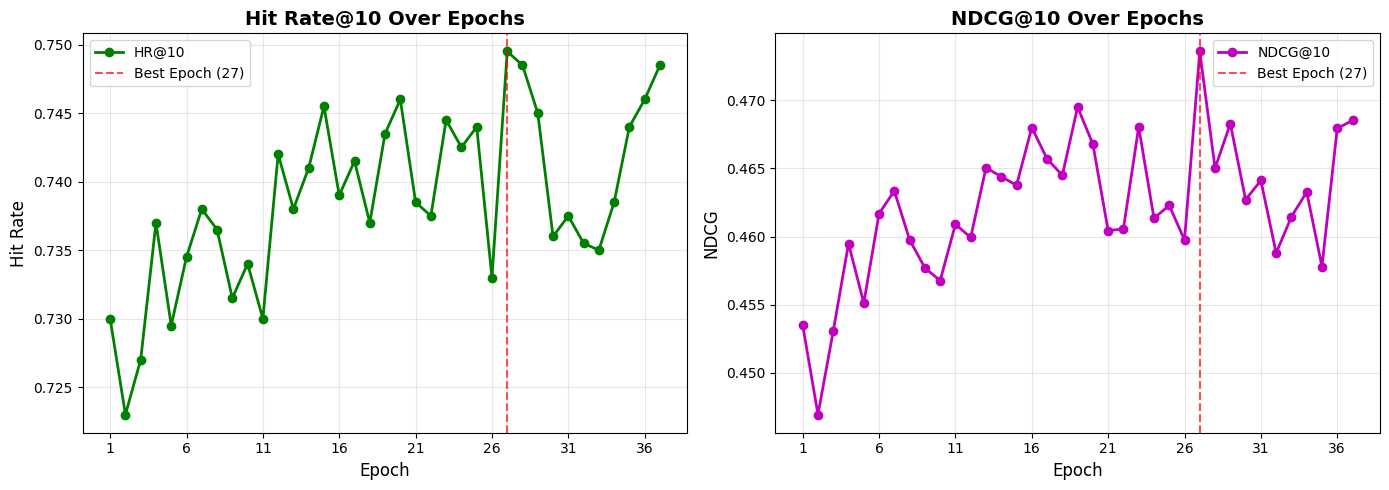


Final Training Metrics
Best HR@10: 0.7495 (Epoch 27)
Best NDCG@10: 0.4736 (Epoch 27)
Final HR@10: 0.7485
Final NDCG@10: 0.4685


In [34]:
# Visualization of training metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = training_history['epoch']

# Plot 1: Hit Rate
axes[0].plot(epochs, training_history['hit_rate'], 'g-o', label=f'HR@{TOP_K}', linewidth=2, markersize=6)
axes[0].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Hit Rate', fontsize=12)
axes[0].set_title(f'Hit Rate@{TOP_K} Over Epochs', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

# Plot 2: NDCG
axes[1].plot(epochs, training_history['ndcg'], 'm-o', label=f'NDCG@{TOP_K}', linewidth=2, markersize=6)
axes[1].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('NDCG', fontsize=12)
axes[1].set_title(f'NDCG@{TOP_K} Over Epochs', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "=" * 70)
print("Final Training Metrics")
print("=" * 70)
print(f"Best HR@{TOP_K}: {best_hr:.4f} (Epoch {best_epoch + 1})")
print(f"Best NDCG@{TOP_K}: {best_ndcg:.4f} (Epoch {best_epoch + 1})")
if training_history['hit_rate']:
    print(f"Final HR@{TOP_K}: {training_history['hit_rate'][-1]:.4f}")
    print(f"Final NDCG@{TOP_K}: {training_history['ndcg'][-1]:.4f}")
print("=" * 70)

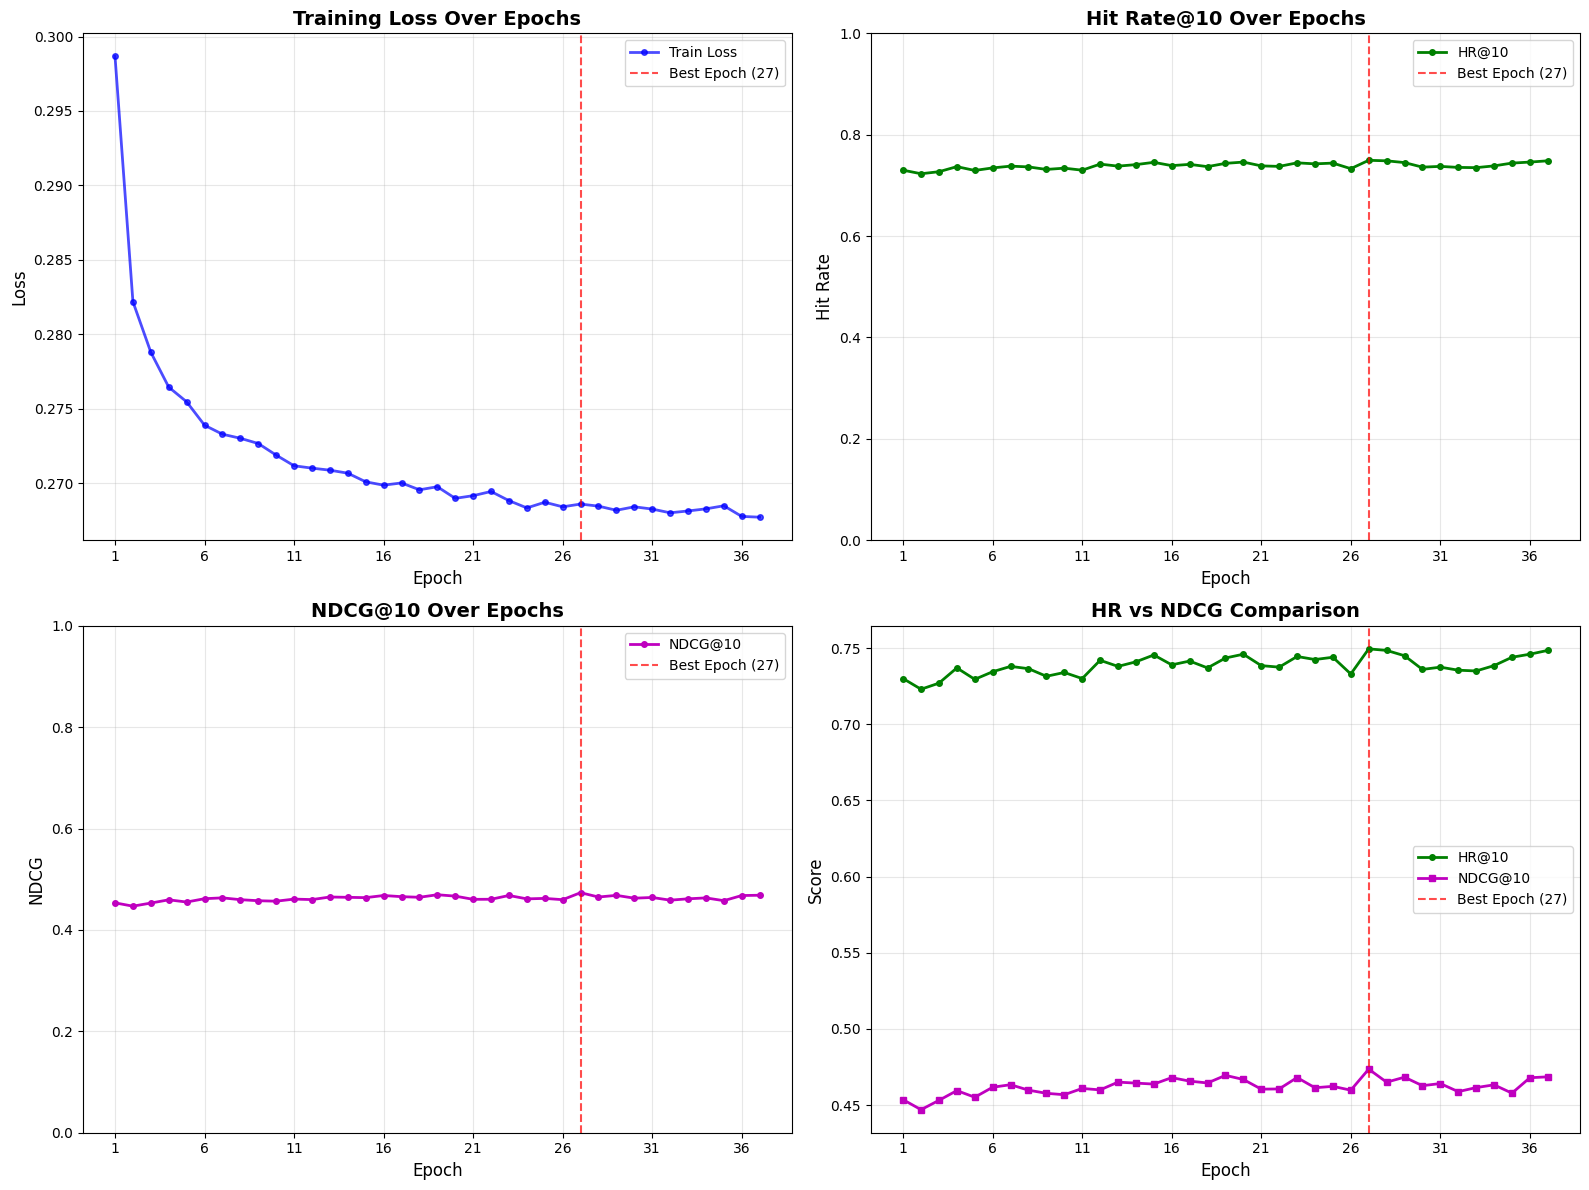

In [42]:
# ==================== COMPREHENSIVE VISUALIZATIONS ====================

# 1. Training Metrics Overview
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = training_history['epoch']

# Plot 1: Training Loss
axes[0, 0].plot(epochs, training_history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4, alpha=0.7)
axes[0, 0].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

# Plot 2: Hit Rate
axes[0, 1].plot(epochs, training_history['hit_rate'], 'g-o', label=f'HR@{TOP_K}', linewidth=2, markersize=4)
axes[0, 1].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Hit Rate', fontsize=12)
axes[0, 1].set_title(f'Hit Rate@{TOP_K} Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)
if training_history['hit_rate']:
    axes[0, 1].set_ylim([0, max(1.0, max(training_history['hit_rate']) * 1.1)])

# Plot 3: NDCG
axes[1, 0].plot(epochs, training_history['ndcg'], 'm-o', label=f'NDCG@{TOP_K}', linewidth=2, markersize=4)
axes[1, 0].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('NDCG', fontsize=12)
axes[1, 0].set_title(f'NDCG@{TOP_K} Over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)
if training_history['ndcg']:
    axes[1, 0].set_ylim([0, max(1.0, max(training_history['ndcg']) * 1.1)])

# Plot 4: HR vs NDCG Comparison
axes[1, 1].plot(epochs, training_history['hit_rate'], 'g-o', label=f'HR@{TOP_K}', linewidth=2, markersize=4)
axes[1, 1].plot(epochs, training_history['ndcg'], 'm-s', label=f'NDCG@{TOP_K}', linewidth=2, markersize=4)
axes[1, 1].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('HR vs NDCG Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

plt.tight_layout()
plt.show()

In [ ]:
# 4. Performance Across Different K Values
# Define aliases for consistency
num_users = user_num
num_items = item_num

print("\nEvaluating performance across different K values...")
k_values = [5, 10, 20, 50]
k_hr_scores = []
k_ndcg_scores = []

for k in k_values:
    hr_k, ndcg_k = evaluate_ranking_metrics(
        model, train_mat_dense, test_mat_dense, num_users, num_items, top_k=k, device=device
    )
    k_hr_scores.append(hr_k)
    k_ndcg_scores.append(ndcg_k)
    print(f"  K={k:2d}: HR@{k}={hr_k:.4f}, NDCG@{k}={ndcg_k:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: HR@K for different K
axes[0].plot(k_values, k_hr_scores, 'g-o', linewidth=2, markersize=8, label='Hit Rate')
axes[0].set_xlabel('K (Top-K)', fontsize=12)
axes[0].set_ylabel('Hit Rate', fontsize=12)
axes[0].set_title('Hit Rate@K for Different K Values', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(k_values)
for k, hr in zip(k_values, k_hr_scores):
    axes[0].text(k, hr + 0.01, f'{hr:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 2: NDCG@K for different K
axes[1].plot(k_values, k_ndcg_scores, 'm-s', linewidth=2, markersize=8, label='NDCG')
axes[1].set_xlabel('K (Top-K)', fontsize=12)
axes[1].set_ylabel('NDCG', fontsize=12)
axes[1].set_title('NDCG@K for Different K Values', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(k_values)
for k, ndcg in zip(k_values, k_ndcg_scores):
    axes[1].text(k, ndcg + 0.01, f'{ndcg:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Evaluating performance across different K values...
